In [47]:
import numpy as np
import pandas as pd
import pickle
import time
import os
import csv
import shutil

import SimpleITK as sitk
import matplotlib.pyplot as plt
import pydicom
import imageio
import glob
import boto3

from lungmask import LMInferer

from tqdm.notebook import tqdm
from collections import namedtuple

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# Downloads files from S3 Bucket

In [91]:
#!aws s3 sync s3://fastvision.ai/raw-data/luna16/segmented2mm/ luna16/segment

## Function to resample the CT scan volume to a given voxel size

In [22]:
def resample_volume(volume_path, interpolator = sitk.sitkLinear, new_spacing = [1,1, 1]):
    volume = sitk.ReadImage(volume_path) # read and cast to float32
    original_spacing = volume.GetSpacing()
    original_size = volume.GetSize()
    new_size = [int(round(osz*ospc/nspc)) for osz,ospc,nspc in zip(original_size, original_spacing, new_spacing)]
    return sitk.Resample(volume, new_size, sitk.Transform(), interpolator,
                         volume.GetOrigin(), new_spacing, volume.GetDirection(), interpolator,
                         volume.GetPixelID())

## Functions to Segment Lungs from CT Scan

In [5]:
def inferer_mask(ct_scan_volume, offset=0):
    '''
    Input is 3D numpy array of original CT scan and output is 3D numpy array of generated mask
    '''
    #Defines numpy offset to allow segmentation to work across different datasets (LUNA16 doesn't need)
    ct_scan_volume -= offset
    mask_slices = []
    lung_mask_volume = inferer.apply(ct_scan_volume)
    for slice_idx in range(ct_scan_volume.shape[0]):
        mask_slices.append(lung_mask_volume[slice_idx, :, :])

    mask_slices = np.stack(mask_slices, axis=0)
    
    return mask_slices

In [20]:
def segmented_inferer_volume(ct_scan,offset=0):
    '''
    Input is 3D numpy array of original CT scan and output is 3D numpy array of segmented volume
    '''
    #Defines numpy offset to allow segmentation to work across different datasets (LUNA16 doesn't need)
    ct_scan -= offset
    lung_mask_volume = inferer_mask(ct_scan)
    segmented_slices = []
    tracker = []
    for slice_idx in range(ct_scan.shape[0]):
        ct_slice = ct_scan[slice_idx, :, :]
        lung_mask_slice = lung_mask_volume[slice_idx, :, :]
        masked_slice = np.where(lung_mask_slice != 0, ct_slice, np.min(ct_slice))
        segmented_slices.append(masked_slice)
        
        #keeps track of value ranges only in lungs
        tracker_slice = np.where(lung_mask_slice != 0, ct_slice, -99999)
        tracker.append(tracker_slice)
        
    segmented_slices = np.stack(segmented_slices, axis=0)
    
    # Concatenate the arrays into a single array
    concatenated_array = np.concatenate(tracker)
    
    # Filter the array to exclude values equal to 999
    concatenated_array  = concatenated_array[concatenated_array  != -99999]

    # Find the minimum and maximum values inside lung volume
    min_value = np.min(concatenated_array)
    max_value = np.max(concatenated_array)

    # Normalize the segmented volume to a range of 0 to 1
    segmented_slices = (segmented_slices - min_value) / (max_value - min_value)
    
    #Replace background with 0's
    background_value = segmented_slices[0][0][0]
    segmented_slices = np.where(segmented_slices == background_value, 0, segmented_slices)
    
    
    return segmented_slices

In [17]:
def remove_blank_slices(segmented_ct_scan,ct_scan=None):
    '''
    Input is 3D numpy array of segmented volume and output is numpy array slices that only contain lung volume
    
    If ct_scan file is added, it will remove the correlated slice from the original CT scan for comparison
    '''
    segment_result = []
    ct = []
    # Iterate through each slice 
    for slice_2d in range(segmented_ct_scan.shape[0]):
        # Check if all elements in the slice have the same value
        if not np.all(segmented_ct_scan[slice_2d] == segmented_ct_scan[slice_2d][0]):
            segment_result.append(segmented_ct_scan[slice_2d, :, :])
            if ct_scan is not None:
                ct.append(ct_scan[slice_2d, :, :])

    # Convert the result back to a NumPy array
    segment_result = np.stack(segment_result, axis=0)
    
    if ct_scan is not None:
        ct = np.stack(ct, axis=0)
        return segment_result, ct
    else:
        return segment_result

# Deletes Files in Folder

In [46]:
#import os

# Set the path to the directory you want to clear
#directory_path = 'luna16/segment_normalized2mm'

# Iterate through the files in the directory
#for filename in os.listdir(directory_path):
#    file_path = os.path.join(directory_path, filename)
#    if os.path.isfile(file_path):
#        # Remove each file
#        os.remove(file_path)

# Uploads files to S3 Bucket (Don't Run Unless Data is Ready)

In [43]:
import os
import boto3

# Set the name of your S3 bucket
bucket_name = 'fastvision.ai'

# Set the subfolder path within the bucket
subfolder_path = 'raw-data/luna16/segmented_normalized_2mm/'

# Set the path to your SageMaker folder
folder_path = 'luna16/segment_normalized2mm'

# Create an S3 client
s3_client = boto3.client('s3')

# Iterate through the files in the SageMaker folder
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        # Set the S3 key by combining the subfolder path and the filename
        s3_key = subfolder_path + filename
        
        # Upload the file to the S3 bucket
        s3_client.upload_file(file_path, bucket_name, s3_key)

In [45]:
#!ls luna16/segment_normalized2mm

## Segmentation Pipeline Demonstration

In [41]:
#Initialize lungmask inferer
inferer = LMInferer()

# Set the path to folder containing mhd and raw files
input_folder_path = 'luna16/'

# Set the path to your output folder for storing resampled files
output_folder_path = 'luna16/segment_normalized2mm'

# Use glob to retrieve a list of .mhd file paths within the input folder
mhd_file_paths = glob.glob(os.path.join(input_folder_path, '*.mhd'))

# Normalize voxel size for each file, segment lungs, and save as new file
for file_path in mhd_file_paths:
    ct_scan_resampled = resample_volume(file_path,new_spacing = [2, 2, 2])
    file_name = os.path.basename(file_path)  # Get the file name
    output_file_path = os.path.join(output_folder_path, file_name)
    #sitk.WriteImage(ct_scan_resampled, output_file_path)
    ct_scan_resampled = np.array(sitk.GetArrayFromImage(ct_scan_resampled), dtype=np.float32)
    
    unet_segmented_volume = segmented_inferer_volume(ct_scan_resampled)
    unet_trimmed_volume = remove_blank_slices(unet_segmented_volume)
    min_value = np.min(unet_trimmed_volume)

    # Define the target shape
    target_shape = (256, 256, 256)

    # Calculate the required padding for each dimension
    pad_depth = max(target_shape[0] - unet_trimmed_volume.shape[0], 0)
    pad_height = max(target_shape[1] - unet_trimmed_volume.shape[1], 0)
    pad_width = max(target_shape[2] - unet_trimmed_volume.shape[2], 0)

    # Calculate the padding amounts for each side of each dimension
    pad_depth_before = pad_depth // 2
    pad_depth_after = pad_depth - pad_depth_before

    pad_height_before = pad_height // 2
    pad_height_after = pad_height - pad_height_before

    pad_width_before = pad_width // 2
    pad_width_after = pad_width - pad_width_before

    # Pad the array with the minimum value
    padded_data = np.pad(unet_trimmed_volume, ((pad_depth_before, pad_depth_after), (pad_height_before, pad_height_after), (pad_width_before, pad_width_after)), mode='constant', constant_values=min_value)
    
    #normalize all values to be between 0 and 1
    padded_data_norm = (padded_data-np.min(padded_data))/(np.max(padded_data)-np.min(padded_data))
    
    image_sitk = sitk.GetImageFromArray(padded_data_norm)
    sitk.WriteImage(image_sitk, output_file_path)
        
    # Use the os.listdir() function to get a list of items in the folder
    items = os.listdir(output_folder_path)
    print(items[-1])

10it [00:03,  2.88it/s]                         

lungmask 2023-07-12 02:45:22 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 325.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.raw


105%|██████████| 9/8.6 [00:03<00:00,  2.82it/s]

lungmask 2023-07-12 02:45:29 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 260.60it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.80it/s]

lungmask 2023-07-12 02:45:35 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 358.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.79it/s]

lungmask 2023-07-12 02:45:43 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 109.70it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.raw


8it [00:02,  2.83it/s]                         

lungmask 2023-07-12 02:45:50 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 97.68it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.raw


8it [00:02,  2.94it/s]                          

lungmask 2023-07-12 02:45:57 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 116.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.199171741859530285887752432478.raw


103%|██████████| 7/6.8 [00:02<00:00,  2.79it/s]

lungmask 2023-07-12 02:46:02 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 677.65it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


8it [00:02,  2.89it/s]                          

lungmask 2023-07-12 02:46:09 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 67.75it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


100%|██████████| 8/8.0 [00:02<00:00,  2.69it/s]

lungmask 2023-07-12 02:46:16 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 80.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


107%|██████████| 7/6.55 [00:02<00:00,  2.89it/s]

lungmask 2023-07-12 02:46:22 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 136.89it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.66it/s]

lungmask 2023-07-12 02:46:29 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 80.45it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


8it [00:02,  2.84it/s]                          

lungmask 2023-07-12 02:46:36 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 129.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


104%|██████████| 6/5.75 [00:02<00:00,  2.80it/s]

lungmask 2023-07-12 02:46:42 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 167.96it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


9it [00:03,  2.94it/s]                          

lungmask 2023-07-12 02:46:48 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 90.67it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.84it/s]

lungmask 2023-07-12 02:46:56 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 69.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


7it [00:02,  3.00it/s]                          

lungmask 2023-07-12 02:47:02 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 83.14it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.395623571499047043765181005112.raw


8it [00:02,  2.87it/s]                         

lungmask 2023-07-12 02:47:07 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 769.60it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.147250707071097813243473865421.raw


9it [00:03,  2.84it/s]                          

lungmask 2023-07-12 02:47:13 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 64.46it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.raw


9it [00:03,  2.98it/s]                          

lungmask 2023-07-12 02:47:20 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 81.55it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270152671889301412052226973069.raw


9it [00:03,  2.89it/s]                         

lungmask 2023-07-12 02:47:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 346.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.232011770495640253949434620907.raw


8it [00:02,  2.85it/s]                         

lungmask 2023-07-12 02:47:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 461.09it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.raw


8it [00:02,  2.95it/s]                         

lungmask 2023-07-12 02:47:39 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 366.14it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.raw


9it [00:03,  2.93it/s]                         

lungmask 2023-07-12 02:47:45 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 889.52it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.raw


8it [00:02,  2.96it/s]                         

lungmask 2023-07-12 02:47:51 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 89.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.657775098760536289051744981056.raw


10it [00:03,  2.88it/s]                        

lungmask 2023-07-12 02:47:58 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 139.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.198698492013538481395497694975.raw


104%|██████████| 7/6.75 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 02:48:04 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 388.33it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


8it [00:02,  2.82it/s]                         

lungmask 2023-07-12 02:48:10 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 172.40it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 02:48:17 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 126.93it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


9it [00:03,  2.90it/s]                          

lungmask 2023-07-12 02:48:24 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 390.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


9it [00:03,  2.98it/s]                          

lungmask 2023-07-12 02:48:31 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 121.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


9it [00:03,  2.89it/s]                         

lungmask 2023-07-12 02:48:38 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 107.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.85it/s]

lungmask 2023-07-12 02:48:45 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 127.47it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.970264865033574190975654369557.raw


8it [00:02,  2.83it/s]                          

lungmask 2023-07-12 02:48:51 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 419.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.200837896655745926888305239398.raw


8it [00:02,  2.93it/s]                          

lungmask 2023-07-12 02:48:57 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 379.25it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.83it/s]

lungmask 2023-07-12 02:49:04 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 378.00it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.raw


7it [00:02,  3.03it/s]                          

lungmask 2023-07-12 02:49:10 Postprocessing



100%|██████████| 23/23 [00:00<00:00, 91.72it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.57it/s]

lungmask 2023-07-12 02:49:16 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 158.30it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.raw


8it [00:02,  2.85it/s]                         

lungmask 2023-07-12 02:49:22 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 467.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.776429308535398795601496131524.raw


8it [00:02,  2.84it/s]                          

lungmask 2023-07-12 02:49:28 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 529.62it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.raw


9it [00:03,  2.93it/s]                         

lungmask 2023-07-12 02:49:35 Postprocessing



100%|██████████| 24/24 [00:00<00:00, 63.37it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.81it/s]

lungmask 2023-07-12 02:49:41 Postprocessing



100%|██████████| 26/26 [00:00<00:00, 59.48it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.293757615532132808762625441831.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.68it/s]

lungmask 2023-07-12 02:49:48 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 143.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


9it [00:03,  2.94it/s]                          

lungmask 2023-07-12 02:49:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 352.76it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


103%|██████████| 7/6.8 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 02:50:00 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 97.75it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


100%|██████████| 9/9.0 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 02:50:06 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 65.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.76it/s]

lungmask 2023-07-12 02:50:13 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 84.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


101%|██████████| 9/8.95 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 02:50:21 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 367.78it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


9it [00:03,  2.93it/s]                          

lungmask 2023-07-12 02:50:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 370.49it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250438451287314206124484591986.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 02:50:34 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 82.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.299767339686526858593516834230.raw


9it [00:03,  2.88it/s]                         

lungmask 2023-07-12 02:50:40 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 73.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.raw


8it [00:02,  2.82it/s]                         

lungmask 2023-07-12 02:50:47 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 418.57it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 02:50:54 Postprocessing



100%|██████████| 12/12 [00:00<00:00, 64.78it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.raw


10it [00:03,  2.91it/s]                        

lungmask 2023-07-12 02:51:02 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 161.61it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.272190966764020277652079081128.raw


8it [00:02,  2.85it/s]                         

lungmask 2023-07-12 02:51:09 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 126.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.390513733720659266816639651938.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.63it/s]

lungmask 2023-07-12 02:51:15 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 432.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.raw


101%|██████████| 7/6.95 [00:02<00:00,  2.63it/s]

lungmask 2023-07-12 02:51:21 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 461.78it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.raw


8it [00:02,  2.97it/s]                          

lungmask 2023-07-12 02:51:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 429.30it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.raw


8it [00:02,  2.83it/s]                          

lungmask 2023-07-12 02:51:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 470.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.raw


8it [00:02,  2.79it/s]                          

lungmask 2023-07-12 02:51:40 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 101.08it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.143412474064515942785157561636.raw


9it [00:03,  2.89it/s]                         

lungmask 2023-07-12 02:51:46 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 313.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.125067060506283419853742462394.raw


10it [00:03,  2.86it/s]                        

lungmask 2023-07-12 02:51:54 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 140.03it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


9it [00:03,  2.84it/s]                          

lungmask 2023-07-12 02:52:01 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 158.37it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 02:52:07 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 478.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


7it [00:02,  2.81it/s]                          

lungmask 2023-07-12 02:52:13 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 513.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 02:52:20 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 108.86it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 02:52:26 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 105.29it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


8it [00:02,  2.77it/s]                         

lungmask 2023-07-12 02:52:32 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 82.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267957701183569638795986183786.raw


100%|██████████| 5/5.0 [00:01<00:00,  2.58it/s]

lungmask 2023-07-12 02:52:37 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 749.85it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.raw


8it [00:02,  2.86it/s]                          

lungmask 2023-07-12 02:52:43 Postprocessing



100%|██████████| 13/13 [00:00<00:00, 68.14it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.898642529028521482602829374444.raw


8it [00:02,  2.80it/s]                         

lungmask 2023-07-12 02:52:49 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 79.64it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.185226274332527104841463955058.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 02:52:55 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 93.29it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.raw


8it [00:02,  2.80it/s]                          

lungmask 2023-07-12 02:53:01 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 151.69it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.71it/s]

lungmask 2023-07-12 02:53:08 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 502.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.70it/s]

lungmask 2023-07-12 02:53:14 Postprocessing



100%|██████████| 17/17 [00:00<00:00, 62.41it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw


9it [00:03,  2.90it/s]                         

lungmask 2023-07-12 02:53:21 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 331.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 02:53:28 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 91.59it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.raw


8it [00:02,  2.94it/s]                          

lungmask 2023-07-12 02:53:34 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 86.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.70it/s]

lungmask 2023-07-12 02:53:40 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 112.46it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 02:53:47 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 487.62it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 02:53:53 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 74.24it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.625270601160880745954773142570.raw


8it [00:02,  2.86it/s]                         

lungmask 2023-07-12 02:54:00 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 128.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.253322967203074795232627653819.raw


10it [00:03,  2.81it/s]                        

lungmask 2023-07-12 02:54:07 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 65.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.raw


105%|██████████| 8/7.65 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 02:54:15 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 482.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.250863365157630276148828903732.raw


105%|██████████| 7/6.65 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 02:54:21 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 149.90it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.267519732763035023633235877753.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.76it/s]

lungmask 2023-07-12 02:54:27 Postprocessing



100%|██████████| 26/26 [00:00<00:00, 78.45it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.raw


103%|██████████| 7/6.8 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 02:54:34 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 553.19it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.69it/s]

lungmask 2023-07-12 02:54:39 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 123.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.raw


9it [00:03,  2.89it/s]                          

lungmask 2023-07-12 02:54:46 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 366.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 02:54:52 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 100.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.130438550890816550994739120843.raw


9it [00:03,  2.91it/s]                         

lungmask 2023-07-12 02:54:59 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 372.63it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.336894364358709782463716339027.raw


8it [00:02,  2.89it/s]                          

lungmask 2023-07-12 02:55:05 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 184.28it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 02:55:12 Postprocessing



100%|██████████| 16/16 [00:00<00:00, 75.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.raw


9it [00:03,  2.75it/s]                         

lungmask 2023-07-12 02:55:19 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 302.74it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.534083630500464995109143618896.raw


9it [00:03,  2.74it/s]                         

lungmask 2023-07-12 02:55:26 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 378.89it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.385151742584074711135621089321.raw


101%|██████████| 8/7.9 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 02:55:32 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 364.23it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.raw


102%|██████████| 6/5.9 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 02:55:38 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 941.55it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.raw


9it [00:03,  2.87it/s]                          

lungmask 2023-07-12 02:55:44 Postprocessing



100%|██████████| 18/18 [00:00<00:00, 63.61it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 02:55:51 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 164.80it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.raw


105%|██████████| 7/6.65 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 02:55:57 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 473.99it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 02:56:03 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 315.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.404364125369979066736354549484.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 02:56:11 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 308.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.139444426690868429919252698606.raw


101%|██████████| 9/8.95 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 02:56:18 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 113.30it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.raw


8it [00:02,  2.88it/s]                         

lungmask 2023-07-12 02:56:24 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 137.65it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 02:56:30 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 418.34it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.72it/s]

lungmask 2023-07-12 02:56:37 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 129.81it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 02:56:43 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 623.13it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.raw


105%|██████████| 10/9.55 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 02:56:50 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 67.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.225154811831720426832024114593.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 02:56:57 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 107.79it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.raw


8it [00:02,  2.89it/s]                          

lungmask 2023-07-12 02:57:04 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 376.39it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.raw


8it [00:02,  2.77it/s]                         

lungmask 2023-07-12 02:57:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 403.43it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.826829446346820089862659555750.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 02:57:17 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 78.09it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.raw


9it [00:03,  2.75it/s]                         

lungmask 2023-07-12 02:57:24 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 400.43it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 02:57:31 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 405.17it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.raw


7it [00:02,  2.91it/s]                          

lungmask 2023-07-12 02:57:37 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 185.39it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.raw


10it [00:03,  2.89it/s]                         

lungmask 2023-07-12 02:57:43 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 83.87it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.268992195564407418480563388746.raw


9it [00:03,  2.82it/s]                          

lungmask 2023-07-12 02:57:51 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 268.83it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.265960756233787099041040311282.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 02:57:57 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 493.07it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.raw


9it [00:03,  2.81it/s]                         

lungmask 2023-07-12 02:58:04 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 91.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.raw


104%|██████████| 10/9.6 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 02:58:12 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 58.39it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 02:58:19 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 450.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 02:58:26 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 595.99it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.raw


10it [00:03,  2.79it/s]                        

lungmask 2023-07-12 02:58:33 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 98.99it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.300146276266881736689307479986.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.77it/s]

lungmask 2023-07-12 02:58:40 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 119.62it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.177685820605315926524514718990.raw


10it [00:03,  2.78it/s]                        

lungmask 2023-07-12 02:58:48 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 77.02it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 02:58:55 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 620.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.70it/s]

lungmask 2023-07-12 02:59:02 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 451.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.raw


9it [00:03,  2.86it/s]                         

lungmask 2023-07-12 02:59:08 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 285.76it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.raw


102%|██████████| 9/8.85 [00:03<00:00,  2.65it/s]

lungmask 2023-07-12 02:59:16 Postprocessing



100%|██████████| 66/66 [00:01<00:00, 60.52it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.raw


106%|██████████| 6/5.65 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 02:59:23 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 124.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.154703816225841204080664115280.raw


8it [00:02,  2.86it/s]                         

lungmask 2023-07-12 02:59:29 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 80.77it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.210426531621179400035178209430.raw


9it [00:03,  2.84it/s]                          

lungmask 2023-07-12 02:59:35 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 116.42it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.146603910507557786636779705509.raw


10it [00:03,  2.82it/s]                        

lungmask 2023-07-12 02:59:43 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 54.19it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.479402560265137632920333093071.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 02:59:49 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 128.28it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.811825890493256320617655474043.raw


9it [00:03,  2.74it/s]                         

lungmask 2023-07-12 02:59:56 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 76.10it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


105%|██████████| 8/7.65 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:00:03 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 658.07it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:00:10 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 168.64it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


9it [00:03,  2.90it/s]                         

lungmask 2023-07-12 03:00:17 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 224.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


10it [00:03,  2.86it/s]                        

lungmask 2023-07-12 03:00:24 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 381.84it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


8it [00:02,  2.78it/s]                          

lungmask 2023-07-12 03:00:31 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 408.60it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


9it [00:03,  2.81it/s]                         

lungmask 2023-07-12 03:00:38 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 523.31it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.126631670596873065041988320084.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:00:45 Postprocessing



100%|██████████| 18/18 [00:00<00:00, 70.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.268838889380981659524993261082.raw


10it [00:03,  2.85it/s]                         

lungmask 2023-07-12 03:00:53 Postprocessing



100%|██████████| 15/15 [00:00<00:00, 96.77it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.430109407146633213496148200410.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.70it/s]

lungmask 2023-07-12 03:01:00 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 397.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 03:01:07 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 561.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


8it [00:02,  2.90it/s]                         

lungmask 2023-07-12 03:01:13 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 674.65it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.71it/s]

lungmask 2023-07-12 03:01:20 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 79.43it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


9it [00:03,  2.85it/s]                          

lungmask 2023-07-12 03:01:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 341.31it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


105%|██████████| 9/8.6 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 03:01:34 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 363.62it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.76it/s]

lungmask 2023-07-12 03:01:41 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 424.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.216882370221919561230873289517.raw


9it [00:03,  2.91it/s]                         

lungmask 2023-07-12 03:01:48 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 61.87it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 03:01:55 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 90.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.72it/s]

lungmask 2023-07-12 03:02:02 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 436.41it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


103%|██████████| 10/9.75 [00:03<00:00,  2.69it/s]

lungmask 2023-07-12 03:02:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 250.12it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.70it/s]

lungmask 2023-07-12 03:02:18 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 90.23it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


11it [00:03,  2.75it/s]                          

lungmask 2023-07-12 03:02:27 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 130.45it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:02:35 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 350.74it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


8it [00:02,  2.86it/s]                          

lungmask 2023-07-12 03:02:41 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 178.67it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231834776365874788440767645596.raw


8it [00:02,  2.78it/s]                         

lungmask 2023-07-12 03:02:47 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 124.09it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.230078008964732806419498631442.raw


10it [00:03,  2.77it/s]                         

lungmask 2023-07-12 03:02:55 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 97.81it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.59it/s]

lungmask 2023-07-12 03:03:02 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 139.95it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.raw


8it [00:02,  2.81it/s]                          

lungmask 2023-07-12 03:03:09 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 103.05it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.raw


8it [00:02,  2.78it/s]                         

lungmask 2023-07-12 03:03:15 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 125.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.428038562098395445838061018440.raw


9it [00:03,  2.89it/s]                         

lungmask 2023-07-12 03:03:22 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 495.45it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.227885601428639043345478571594.raw


101%|██████████| 8/7.9 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:03:30 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 420.08it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.raw


8it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:03:37 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 527.96it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.259543921154154401875872845498.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:03:44 Postprocessing



100%|██████████| 15/15 [00:00<00:00, 61.96it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.71it/s]

lungmask 2023-07-12 03:03:51 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 106.58it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231002159523969307155990628066.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 03:03:58 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 578.60it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.183924380327950237519832859527.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 03:04:05 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 59.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:04:13 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 102.54it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.333145094436144085379032922488.raw


104%|██████████| 10/9.65 [00:03<00:00,  2.70it/s]

lungmask 2023-07-12 03:04:20 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 298.90it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.141430002307216644912805017227.raw


7it [00:02,  2.84it/s]                          

lungmask 2023-07-12 03:04:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 463.31it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 03:04:33 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 72.45it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.265133389948279331857097127422.raw


8it [00:02,  2.97it/s]                          

lungmask 2023-07-12 03:04:39 Postprocessing



100%|██████████| 14/14 [00:00<00:00, 83.36it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.raw


10it [00:03,  2.78it/s]                        

lungmask 2023-07-12 03:04:48 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 278.13it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.raw


8it [00:02,  2.81it/s]                          

lungmask 2023-07-12 03:04:55 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 372.41it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.raw


8it [00:02,  2.77it/s]                         

lungmask 2023-07-12 03:05:02 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 300.05it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.177252583002664900748714851615.raw


8it [00:02,  2.79it/s]                          

lungmask 2023-07-12 03:05:09 Postprocessing



100%|██████████| 14/14 [00:00<00:00, 78.57it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.470912100568074901744259213968.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:05:17 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 112.63it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.raw


9it [00:03,  2.87it/s]                         

lungmask 2023-07-12 03:05:24 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 619.11it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.raw


9it [00:03,  2.77it/s]                          

lungmask 2023-07-12 03:05:32 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 112.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.raw


103%|██████████| 7/6.8 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 03:05:38 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 832.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.raw


9it [00:03,  2.84it/s]                          

lungmask 2023-07-12 03:05:45 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 280.61it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.270215889102603268207599305185.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.75it/s]

lungmask 2023-07-12 03:05:52 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 73.85it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.raw


9it [00:03,  2.80it/s]                         

lungmask 2023-07-12 03:05:59 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 405.56it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.487745546557477250336016826588.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:06:06 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 100.86it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


9it [00:03,  2.78it/s]                         

lungmask 2023-07-12 03:06:15 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 112.16it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:06:21 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 104.45it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 03:06:28 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 107.76it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


8it [00:02,  2.97it/s]                          

lungmask 2023-07-12 03:06:35 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 75.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


6it [00:02,  2.80it/s]                         

lungmask 2023-07-12 03:06:40 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 918.90it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


8it [00:02,  2.78it/s]                         

lungmask 2023-07-12 03:06:46 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 94.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:06:54 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 128.43it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.564534197011295112247542153557.raw


107%|██████████| 7/6.55 [00:02<00:00,  2.79it/s]

lungmask 2023-07-12 03:07:00 Postprocessing



100%|██████████| 61/61 [00:00<00:00, 100.04it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.58it/s]

lungmask 2023-07-12 03:07:07 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 86.96it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.943403138251347598519939390311.raw


102%|██████████| 7/6.85 [00:02<00:00,  2.65it/s]

lungmask 2023-07-12 03:07:13 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 109.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


9it [00:03,  2.75it/s]                          

lungmask 2023-07-12 03:07:20 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 87.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


101%|██████████| 9/8.9 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:07:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 459.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


10it [00:03,  2.78it/s]                        

lungmask 2023-07-12 03:07:34 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 80.40it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:07:42 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 133.46it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:07:49 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 163.23it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


101%|██████████| 8/7.9 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:07:55 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 401.02it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.103115201714075993579787468219.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:08:02 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 581.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.61it/s]

lungmask 2023-07-12 03:08:09 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 548.67it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.raw


10it [00:03,  2.77it/s]                        

lungmask 2023-07-12 03:08:16 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 573.68it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.raw


9it [00:03,  2.80it/s]                         

lungmask 2023-07-12 03:08:23 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 114.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.raw


7it [00:02,  2.85it/s]                         

lungmask 2023-07-12 03:08:30 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 524.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.231645134739451754302647733304.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:08:36 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 124.11it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260.raw


8it [00:02,  2.85it/s]                         

lungmask 2023-07-12 03:08:42 Postprocessing



100%|██████████| 18/18 [00:00<00:00, 69.82it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 03:08:49 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 370.42it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.85it/s]                        

lungmask 2023-07-12 03:08:57 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 306.43it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.77it/s]                         

lungmask 2023-07-12 03:09:05 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 112.24it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 10/9.8 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:09:14 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 276.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.83it/s]                          

lungmask 2023-07-12 03:09:22 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 464.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 7/6.7 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 03:09:29 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 96.05it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.86it/s]                         

lungmask 2023-07-12 03:09:35 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 375.23it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 7/6.6 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:09:41 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 155.19it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 03:09:47 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 563.52it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:09:55 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 119.93it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:10:02 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 126.89it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.77it/s]                         

lungmask 2023-07-12 03:10:11 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 144.60it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 03:10:18 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 496.90it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.70it/s]

lungmask 2023-07-12 03:10:25 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 54.50it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.85it/s]                          

lungmask 2023-07-12 03:10:32 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 123.87it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:10:39 Postprocessing



100%|██████████| 14/14 [00:00<00:00, 91.65it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.94it/s]                          

lungmask 2023-07-12 03:10:47 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 362.36it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.82it/s]                          

lungmask 2023-07-12 03:10:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 310.41it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:11:01 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 58.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 03:11:08 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 74.01it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.70it/s]

lungmask 2023-07-12 03:11:15 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 458.67it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 03:11:21 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 128.70it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 7/6.7 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:11:27 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 113.46it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:11:35 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 111.81it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 03:11:42 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 71.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 7/6.6 [00:02<00:00,  2.79it/s]

lungmask 2023-07-12 03:11:50 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 438.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:11:57 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 75.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 7/6.65 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:12:03 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 153.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.75it/s]

lungmask 2023-07-12 03:12:11 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 68.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:12:18 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 871.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.91it/s]                         

lungmask 2023-07-12 03:12:24 Postprocessing



100%|██████████| 11/11 [00:00<00:00, 79.14it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.81it/s]                          

lungmask 2023-07-12 03:12:32 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 430.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:12:42 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 592.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:12:49 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 423.11it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.89it/s]                          

lungmask 2023-07-12 03:12:57 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 117.69it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.87it/s]                          

lungmask 2023-07-12 03:13:04 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 68.37it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:13:12 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 118.86it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:13:18 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 468.82it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:13:26 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 289.84it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.79it/s]                          

lungmask 2023-07-12 03:13:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 494.64it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.96it/s]                          

lungmask 2023-07-12 03:13:39 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 670.45it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:13:46 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 391.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.84it/s]                        

lungmask 2023-07-12 03:13:53 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 99.46it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.85it/s]                         

lungmask 2023-07-12 03:14:00 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 84.53it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.65it/s]

lungmask 2023-07-12 03:14:07 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 74.24it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.90it/s]                          

lungmask 2023-07-12 03:14:14 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 325.03it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.9 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:14:22 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 462.87it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.76it/s]                        

lungmask 2023-07-12 03:14:30 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 66.90it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.95it/s]                         

lungmask 2023-07-12 03:14:37 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 509.17it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.87it/s]                         

lungmask 2023-07-12 03:14:45 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 361.02it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.88it/s]                          

lungmask 2023-07-12 03:14:53 Postprocessing



100%|██████████| 12/12 [00:00<00:00, 84.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:14:59 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 329.56it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:15:06 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 112.50it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:15:13 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 489.16it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.77it/s]                         

lungmask 2023-07-12 03:15:24 Postprocessing



100%|██████████| 14/14 [00:00<00:00, 54.80it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.89it/s]                          

lungmask 2023-07-12 03:15:31 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 100.31it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 03:15:39 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 306.14it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 7/6.95 [00:02<00:00,  2.61it/s]

lungmask 2023-07-12 03:15:47 Postprocessing



100%|██████████| 12/12 [00:00<00:00, 94.18it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.73it/s]

lungmask 2023-07-12 03:15:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 349.12it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 03:16:02 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 213.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:16:09 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 117.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:16:16 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 1145.61it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 9/8.95 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:16:23 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 312.12it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 03:16:31 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 119.46it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.85it/s]                         

lungmask 2023-07-12 03:16:39 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 86.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.60it/s]

lungmask 2023-07-12 03:16:46 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 100.07it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 6/5.95 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 03:16:52 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 601.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.80it/s]                         

lungmask 2023-07-12 03:16:59 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 402.04it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.81it/s]                         

lungmask 2023-07-12 03:17:08 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 381.63it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.81it/s]                          

lungmask 2023-07-12 03:17:17 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 376.12it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.80it/s]                         

lungmask 2023-07-12 03:17:24 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 116.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.72it/s]

lungmask 2023-07-12 03:17:31 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 101.70it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.89it/s]                          

lungmask 2023-07-12 03:17:39 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 94.07it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.77it/s]                         

lungmask 2023-07-12 03:17:46 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 64.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 9/8.85 [00:03<00:00,  2.65it/s]

lungmask 2023-07-12 03:17:55 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 109.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 7/6.8 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:18:02 Postprocessing



100%|██████████| 42/42 [00:00<00:00, 85.03it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.71it/s]

lungmask 2023-07-12 03:18:09 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 433.18it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.88it/s]                          

lungmask 2023-07-12 03:18:16 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 125.37it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.85it/s]                        

lungmask 2023-07-12 03:18:24 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 302.59it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.79it/s]                         

lungmask 2023-07-12 03:18:32 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 89.42it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.86it/s]                         

lungmask 2023-07-12 03:18:40 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 407.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.92it/s]                         

lungmask 2023-07-12 03:18:49 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 79.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.80it/s]                         

lungmask 2023-07-12 03:18:56 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 124.95it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:19:03 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 93.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:19:11 Postprocessing



100%|██████████| 27/27 [00:00<00:00, 62.84it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:19:19 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 363.79it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.80it/s]                         

lungmask 2023-07-12 03:19:26 Postprocessing



100%|██████████| 32/32 [00:00<00:00, 70.94it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 03:19:34 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 86.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:19:41 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 113.26it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.72it/s]

lungmask 2023-07-12 03:19:49 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 381.34it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.78it/s]                          

lungmask 2023-07-12 03:19:56 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 417.36it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:20:05 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 379.56it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.97it/s]                          

lungmask 2023-07-12 03:20:12 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 182.63it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.81it/s]                         

lungmask 2023-07-12 03:20:19 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 76.57it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 03:20:29 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 406.35it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.98it/s]                         

lungmask 2023-07-12 03:20:36 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 169.67it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:20:44 Postprocessing



100%|██████████| 17/17 [00:00<00:00, 63.76it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.87it/s]                          

lungmask 2023-07-12 03:20:51 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 378.91it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.84it/s]                          

lungmask 2023-07-12 03:21:01 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 312.70it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.65 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 03:21:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 432.47it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 9/8.9 [00:03<00:00,  2.65it/s]

lungmask 2023-07-12 03:21:18 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 83.52it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 7/6.6 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 03:21:26 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 155.93it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:21:35 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 347.58it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.80it/s]                         

lungmask 2023-07-12 03:21:45 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 324.69it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.85it/s]                          

lungmask 2023-07-12 03:21:54 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 146.09it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:22:02 Postprocessing



100%|██████████| 14/14 [00:00<00:00, 79.56it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.81it/s]                          

lungmask 2023-07-12 03:22:12 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 281.29it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:22:19 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 312.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.82it/s]                          

lungmask 2023-07-12 03:22:27 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 475.95it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.87it/s]                        

lungmask 2023-07-12 03:22:35 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 66.12it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.67it/s]

lungmask 2023-07-12 03:22:43 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 382.69it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.94it/s]                         

lungmask 2023-07-12 03:22:51 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 430.96it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 03:22:58 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 118.03it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:23:06 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 376.97it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.89it/s]                         

lungmask 2023-07-12 03:23:14 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 606.77it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.78it/s]                          

lungmask 2023-07-12 03:23:21 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 84.16it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:23:31 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 93.78it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.90it/s]                         

lungmask 2023-07-12 03:23:39 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 463.23it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 9/9.0 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:23:47 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 90.83it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:23:54 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 93.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.65 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:24:02 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 78.76it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:24:11 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 116.64it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.85it/s]                          

lungmask 2023-07-12 03:24:18 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 126.24it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.91it/s]                         

lungmask 2023-07-12 03:24:26 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 91.21it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.72it/s]

lungmask 2023-07-12 03:24:34 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 381.30it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.79it/s]                         

lungmask 2023-07-12 03:24:44 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 401.73it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.83it/s]                          

lungmask 2023-07-12 03:24:54 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 121.08it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.59it/s]

lungmask 2023-07-12 03:25:01 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 128.53it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.85it/s]                          

lungmask 2023-07-12 03:25:09 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 84.03it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:25:16 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 119.07it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.83it/s]                         

lungmask 2023-07-12 03:25:24 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 155.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.82it/s]                          

lungmask 2023-07-12 03:25:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 327.60it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:25:40 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 113.75it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:25:48 Postprocessing



100%|██████████| 21/21 [00:00<00:00, 70.85it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.81it/s]                         

lungmask 2023-07-12 03:25:55 Postprocessing



100%|██████████| 22/22 [00:00<00:00, 75.36it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.82it/s]                          

lungmask 2023-07-12 03:26:05 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 455.31it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.77it/s]                         

lungmask 2023-07-12 03:26:12 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 85.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.59it/s]

lungmask 2023-07-12 03:26:19 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 135.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.81it/s]                          

lungmask 2023-07-12 03:26:29 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 67.38it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.89it/s]                          

lungmask 2023-07-12 03:26:36 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 149.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.92it/s]                          

lungmask 2023-07-12 03:26:44 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 118.13it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:26:50 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 81.84it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 03:26:58 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 119.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:27:06 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 618.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.94it/s]                          

lungmask 2023-07-12 03:27:13 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 121.97it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.81it/s]                         

lungmask 2023-07-12 03:27:21 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 531.40it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.79it/s]                          

lungmask 2023-07-12 03:27:29 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 434.53it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.80it/s]                         

lungmask 2023-07-12 03:27:38 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 428.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:27:45 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 417.74it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 03:27:54 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 83.07it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 9/8.85 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:28:04 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 458.80it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 7/6.95 [00:02<00:00,  2.61it/s]

lungmask 2023-07-12 03:28:11 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 148.88it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.79it/s]

lungmask 2023-07-12 03:28:18 Postprocessing



100%|██████████| 36/36 [00:00<00:00, 71.97it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


107%|██████████| 7/6.55 [00:02<00:00,  2.80it/s]

lungmask 2023-07-12 03:28:26 Postprocessing



100%|██████████| 17/17 [00:00<00:00, 71.44it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 03:28:33 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 80.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


5it [00:01,  3.14it/s]                          

lungmask 2023-07-12 03:28:40 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 240.94it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.86it/s]                          

lungmask 2023-07-12 03:28:46 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 137.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.92it/s]                          

lungmask 2023-07-12 03:28:54 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 282.61it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:29:01 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 75.85it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.76it/s]                          

lungmask 2023-07-12 03:29:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 321.38it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:29:17 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 433.86it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.94it/s]                          

lungmask 2023-07-12 03:29:27 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 116.70it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.90it/s]                          

lungmask 2023-07-12 03:29:35 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 368.54it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.7 [00:03<00:00,  2.75it/s]

lungmask 2023-07-12 03:29:43 Postprocessing



100%|██████████| 7/7 [00:00<00:00, 64.99it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.80it/s]

lungmask 2023-07-12 03:29:53 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 96.80it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.83it/s]                        

lungmask 2023-07-12 03:30:01 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 336.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.91it/s]                         

lungmask 2023-07-12 03:30:08 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 447.77it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 6/5.95 [00:02<00:00,  2.60it/s]

lungmask 2023-07-12 03:30:16 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 161.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.65 [00:02<00:00,  2.77it/s]

lungmask 2023-07-12 03:30:23 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 143.63it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.85it/s]                         

lungmask 2023-07-12 03:30:30 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 71.08it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.65 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:30:38 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 123.29it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.79it/s]                          

lungmask 2023-07-12 03:30:46 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 217.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


10it [00:03,  2.89it/s]                         

lungmask 2023-07-12 03:30:54 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 103.83it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 7/7.0 [00:02<00:00,  2.61it/s]

lungmask 2023-07-12 03:31:02 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 115.08it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.79it/s]                         

lungmask 2023-07-12 03:31:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 380.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:31:18 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 94.29it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.78it/s]                          

lungmask 2023-07-12 03:31:25 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 101.53it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.95it/s]                         

lungmask 2023-07-12 03:31:31 Postprocessing



100%|██████████| 17/17 [00:00<00:00, 91.78it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.91it/s]                          

lungmask 2023-07-12 03:31:38 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 392.08it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.90it/s]                          

lungmask 2023-07-12 03:31:46 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 119.56it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:31:54 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 126.98it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.66it/s]

lungmask 2023-07-12 03:32:02 Postprocessing



100%|██████████| 26/26 [00:00<00:00, 61.17it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 9/8.9 [00:03<00:00,  2.65it/s]

lungmask 2023-07-12 03:32:10 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 83.05it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:32:18 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 79.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.64it/s]

lungmask 2023-07-12 03:32:26 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 127.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:32:33 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 77.42it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.8 [00:02<00:00,  2.71it/s]

lungmask 2023-07-12 03:32:41 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 363.96it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.81it/s]                         

lungmask 2023-07-12 03:32:47 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 197.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:32:56 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 86.34it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:33:03 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 68.79it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.85it/s]                         

lungmask 2023-07-12 03:33:10 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 351.49it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 7/6.7 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:33:17 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 147.09it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.85it/s]                          

lungmask 2023-07-12 03:33:28 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 210.22it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 9/8.55 [00:03<00:00,  2.77it/s]

lungmask 2023-07-12 03:33:36 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 86.15it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.9 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:33:43 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 114.95it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.79it/s]

lungmask 2023-07-12 03:33:51 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 343.53it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 7/6.8 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:34:00 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 110.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 03:34:06 Postprocessing



100%|██████████| 17/17 [00:00<00:00, 70.17it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.74it/s]

lungmask 2023-07-12 03:34:14 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 123.02it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.94it/s]                          

lungmask 2023-07-12 03:34:21 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 121.63it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.89it/s]                         

lungmask 2023-07-12 03:34:30 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 145.21it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.84it/s]                          

lungmask 2023-07-12 03:34:36 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 395.95it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.65it/s]

lungmask 2023-07-12 03:34:44 Postprocessing



100%|██████████| 58/58 [00:00<00:00, 85.20it/s] 


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 8/7.85 [00:03<00:00,  2.65it/s]

lungmask 2023-07-12 03:34:53 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 125.50it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.81it/s]                         

lungmask 2023-07-12 03:35:01 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 130.28it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.83it/s]                         

lungmask 2023-07-12 03:35:09 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 154.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.85it/s]                         

lungmask 2023-07-12 03:35:16 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 170.62it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  3.00it/s]                         

lungmask 2023-07-12 03:35:23 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 227.40it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.87it/s]                          

lungmask 2023-07-12 03:35:33 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 104.34it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


7it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:35:40 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 149.81it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.63it/s]

lungmask 2023-07-12 03:35:48 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 345.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 8/7.75 [00:02<00:00,  2.73it/s]

lungmask 2023-07-12 03:35:56 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 102.68it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.82it/s]                         

lungmask 2023-07-12 03:36:03 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 601.20it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.86it/s]                          

lungmask 2023-07-12 03:36:11 Postprocessing



100%|██████████| 3/3 [00:00<00:00, 117.49it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 10/9.55 [00:03<00:00,  2.76it/s]

lungmask 2023-07-12 03:36:24 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 324.72it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 8/7.6 [00:02<00:00,  2.75it/s]

lungmask 2023-07-12 03:36:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 373.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 7/6.9 [00:02<00:00,  2.62it/s]

lungmask 2023-07-12 03:36:40 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 541.51it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 9/8.6 [00:03<00:00,  2.74it/s]

lungmask 2023-07-12 03:36:48 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 75.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:36:56 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 166.04it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.84it/s]                          

lungmask 2023-07-12 03:37:06 Postprocessing



100%|██████████| 25/25 [00:00<00:00, 66.27it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:37:15 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 162.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


100%|██████████| 8/8.0 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:37:23 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 94.21it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


101%|██████████| 8/7.95 [00:03<00:00,  2.61it/s]

lungmask 2023-07-12 03:37:30 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 94.59it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 03:37:38 Postprocessing



100%|██████████| 6/6 [00:00<00:00, 71.54it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


106%|██████████| 8/7.55 [00:02<00:00,  2.78it/s]

lungmask 2023-07-12 03:37:45 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 480.01it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


103%|██████████| 9/8.75 [00:03<00:00,  2.72it/s]

lungmask 2023-07-12 03:37:53 Postprocessing



100%|██████████| 14/14 [00:00<00:00, 76.02it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


102%|██████████| 9/8.8 [00:03<00:00,  2.71it/s]

lungmask 2023-07-12 03:38:01 Postprocessing



100%|██████████| 15/15 [00:00<00:00, 54.32it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.81it/s]                         

lungmask 2023-07-12 03:38:09 Postprocessing



100%|██████████| 8/8 [00:00<00:00, 76.66it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


6it [00:01,  3.05it/s]                          

lungmask 2023-07-12 03:38:15 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 269.70it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.84it/s]                         

lungmask 2023-07-12 03:38:22 Postprocessing



100%|██████████| 12/12 [00:00<00:00, 61.06it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


8it [00:02,  2.79it/s]                         

lungmask 2023-07-12 03:38:33 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 416.78it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


9it [00:03,  2.89it/s]                          

lungmask 2023-07-12 03:38:42 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 304.79it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 9/8.6 [00:03<00:00,  2.77it/s]

lungmask 2023-07-12 03:38:50 Postprocessing



100%|██████████| 9/9 [00:00<00:00, 83.02it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


105%|██████████| 9/8.6 [00:03<00:00,  2.77it/s]

lungmask 2023-07-12 03:39:01 Postprocessing



100%|██████████| 4/4 [00:00<00:00, 85.92it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.278660284797073139172446973682.raw


104%|██████████| 8/7.7 [00:02<00:00,  2.76it/s]

lungmask 2023-07-12 03:39:09 Postprocessing



100%|██████████| 5/5 [00:00<00:00, 84.24it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd


100%|██████████| 9/9.0 [00:03<00:00,  2.62it/s]

lungmask 2023-07-12 03:39:19 Postprocessing



100%|██████████| 10/10 [00:00<00:00, 73.00it/s]


1.3.6.1.4.1.14519.5.2.1.6279.6001.780558315515979171413904604168.mhd


## Testing Cell to sample output files

(256, 256, 256)


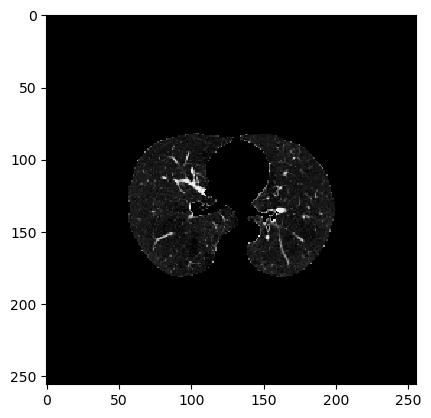

(256, 256, 256)


In [37]:
#List of sample images
mhd_file = sitk.ReadImage('luna16/segment_normalized2mm/1.3.6.1.4.1.14519.5.2.1.6279.6001.631047517458234322522264161877.mhd')
#mhd_file = sitk.ReadImage('luna16/segment_normalized2mm/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.mhd')
#mhd_file = sitk.ReadImage('luna16/segment_normalized2mm/1.3.6.1.4.1.14519.5.2.1.6279.6001.142154819868944114554521645782.mhd')

ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
print(ct_scan.shape)

# Displays an image slice
plt.imshow(ct_scan[128], cmap='gray')
plt.show()
print(ct_scan.shape)

## Testing Cell for Normalization/Padding

10it [00:03,  2.91it/s]                         

lungmask 2023-07-11 14:08:00 Postprocessing



100%|██████████| 2/2 [00:00<00:00, 334.06it/s]


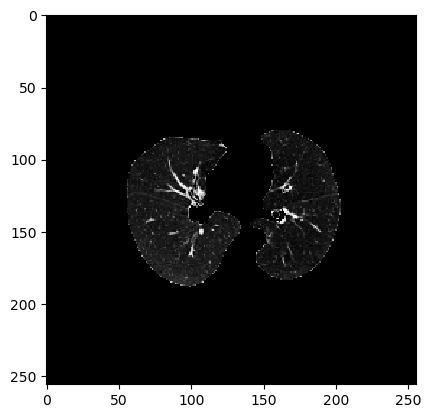

(256, 256, 256)


In [15]:
#Initialize lungmask inferer
inferer = LMInferer()

ct_scan_resampled = resample_volume('luna16/1.3.6.1.4.1.14519.5.2.1.6279.6001.172573195301625265149778785969.mhd',new_spacing = [2, 2, 2])
#sitk.WriteImage(ct_scan_resampled, output_file_path)
ct_scan_resampled = np.array(sitk.GetArrayFromImage(ct_scan_resampled), dtype=np.float32)
unet_segmented_volume = segmented_inferer_volume(ct_scan_resampled)
unet_trimmed_volume = remove_blank_slices(unet_segmented_volume)
min_value = np.min(unet_trimmed_volume)

# Define the target shape
target_shape = (256, 256, 256)

# Calculate the required padding for each dimension
pad_depth = max(target_shape[0] - unet_trimmed_volume.shape[0], 0)
pad_height = max(target_shape[1] - unet_trimmed_volume.shape[1], 0)
pad_width = max(target_shape[2] - unet_trimmed_volume.shape[2], 0)

# Calculate the padding amounts for each side of each dimension
pad_depth_before = pad_depth // 2
pad_depth_after = pad_depth - pad_depth_before

pad_height_before = pad_height // 2
pad_height_after = pad_height - pad_height_before

pad_width_before = pad_width // 2
pad_width_after = pad_width - pad_width_before

# Pad the array with the minimum value
padded_data = np.pad(unet_trimmed_volume, ((pad_depth_before, pad_depth_after), (pad_height_before, pad_height_after), (pad_width_before, pad_width_after)), mode='constant', constant_values=min_value)
#normalize all values to be between 0 and 1
padded_data_norm = (padded_data-np.min(padded_data))/(np.max(padded_data)-np.min(padded_data))

plt.imshow(padded_data_norm[128], cmap='gray')
plt.show()
print(padded_data.shape)

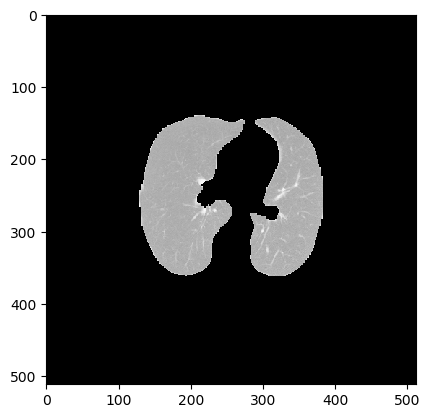

(512, 512, 512)


In [41]:

mhd_file = sitk.ReadImage('luna16/segment1-1/1.3.6.1.4.1.14519.5.2.1.6279.6001.674809958213117379592437424616.mhd')
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
# Displays an image slice
plt.imshow(ct_scan[256], cmap='gray')
plt.show()
print(ct_scan.shape)

# Testing Cell to Check Range of Values 

In [49]:
# Set the path to your folder
folder_path = 'luna16/'

# Iterate through the files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.mhd'):
        # Create the current file path
        current_file_path = os.path.join(folder_path, filename)
        mhd_file = sitk.ReadImage(current_file_path)
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        max_.append(np.amax(ct_scan))
        min_.append(np.amin(ct_scan))
        rang = (np.amax(ct_scan)-np.amin(ct_scan))
        print('Max: ', np.amax(ct_scan))
        print('Min: ', np.amin(ct_scan))
        print('Range: ', rang)

Max:  2617.0
Min:  -1024.0
Range:  3641.0
Max:  2374.0
Min:  -3024.0
Range:  5398.0
Max:  3071.0
Min:  -1024.0
Range:  4095.0
Max:  3071.0
Min:  -1024.0
Range:  4095.0
Max:  2756.0
Min:  -3024.0
Range:  5780.0
Max:  3000.0
Min:  -1000.0
Range:  4000.0
Max:  3071.0
Min:  -2048.0
Range:  5119.0
Max:  3071.0
Min:  -2048.0
Range:  5119.0
Max:  1758.0
Min:  -3024.0
Range:  4782.0
Max:  3071.0
Min:  -3024.0
Range:  6095.0
Max:  3000.0
Min:  -1000.0
Range:  4000.0
Max:  8061.0
Min:  -3023.0
Range:  11084.0
Max:  3072.0
Min:  -3024.0
Range:  6096.0
Max:  2438.0
Min:  -3024.0
Range:  5462.0
Max:  3071.0
Min:  -3024.0
Range:  6095.0
Max:  3071.0
Min:  -2048.0
Range:  5119.0
Max:  2232.0
Min:  -3024.0
Range:  5256.0
Max:  3071.0
Min:  -3024.0
Range:  6095.0
Max:  3071.0
Min:  -2048.0
Range:  5119.0
Max:  2046.0
Min:  -3024.0
Range:  5070.0
Max:  1927.0
Min:  -3024.0
Range:  4951.0
Max:  1629.0
Min:  -3024.0
Range:  4653.0
Max:  3095.0
Min:  -1000.0
Range:  4095.0
Max:  3071.0
Min:  -3024.0
Range:

KeyboardInterrupt: 